In [1]:
from datasets import load_dataset

ds = load_dataset("bahjat-kawar/tedbench", split="val")

In [2]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
text_encoder.eval()
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [4]:
from torch.utils.data import Dataset, DataLoader

class TextGuidedImageGenerationDataset(Dataset):
    def __init__(self, dataset, transform, text_encoder, tokenizer, device):
        self.dataset = dataset
        self.transform = transform
        self.text_encoder = text_encoder
        self.device = device
        self.original_images = dataset["original_image"]
        self.captions = dataset["caption"]
        self.edited_images = dataset["edited_image"]
        self.tokenizer = tokenizer
        self.cache = {}

    def convert_to_rgb(self, image):
        """Convert image to RGB if it has 4 channels (RGBA)"""
        if image.mode == 'RGBA':
            # Convert RGBA to RGB by removing alpha channel
            return image.convert('RGB')
        return image

    def get_embed(self, caption):
        inputs = self.tokenizer(
            caption,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(self.device)
        self.text_encoder.eval()
        with torch.no_grad():
            # Use mean pooling instead of just the first token
            text_features = self.text_encoder(**inputs).last_hidden_state
            # Mean pooling
            text_features = text_features.mean(dim=1)
        return text_features.squeeze(0)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]        

        original_image = self.convert_to_rgb(self.original_images[idx])
        edited_image = self.convert_to_rgb(self.edited_images[idx])
        caption = self.captions[idx]
        caption_embedding = self.get_embed(caption)

        sample = {
            "original_image": self.transform(original_image),
            "edited_image": self.transform(edited_image),
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

        self.cache[idx] = sample
        return sample

train_ds = TextGuidedImageGenerationDataset(
    ds, transform, text_encoder, tokenizer, device
)
train_loader = DataLoader(train_ds, batch_size=25, shuffle=True)

In [5]:
sample = next(iter(train_ds))

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


## **Model**

In [6]:
import math
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(num_channels, num_channels*2, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(num_channels*2, num_channels*4, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1) # shape: (batch_size, num_channels*4, 1, 1)
        )

        self.embedding_layer = nn.Linear(embedding_dim, num_channels*4)
        self.fc = nn.Linear(num_channels*12, num_channels*4)

    def forward(self, t, x, text_embeddings=None, original_image=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if (text_embeddings is not None) and (original_image is not None):
            text_embedded = self.embedding_layer(text_embeddings)
            image_embedded = self.image_encoder(original_image).squeeze(2).squeeze(2)
            emb = torch.cat([emb, text_embedded, image_embedded], dim=1) # 128*3
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

In [7]:
model = UNetModelWithTextEmbedding(
    dim=(3, 256, 256), num_channels=32, num_res_blocks=1, embedding_dim=512, dropout=0.05, num_heads=4
).to(device)
optimizer = torch.optim.AdamW(model.parameters())

In [8]:
from tqdm import tqdm

n_epochs = 4000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

for epoch in tqdm(range(n_epochs)):
    losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        x1 = batch["edited_image"].to(device)
        cond_image = batch["original_image"].to(device)
        text_embeddings = batch["caption_embedding"].to(device)

        x0 = torch.randn_like(x1).to(device)

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x0
        ut = x1 - x0

        t = t.squeeze()

        vt = model(t, xt, text_embeddings=text_embeddings, original_image=cond_image)

        loss = torch.mean(((vt - ut) ** 2))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

  2%|▎         | 100/4000 [01:31<57:37,  1.13it/s] 

Epoch [100/4000], Loss: 0.1239


  5%|▌         | 200/4000 [03:04<1:00:56,  1.04it/s]

Epoch [200/4000], Loss: 0.0696


  8%|▊         | 300/4000 [04:35<56:07,  1.10it/s]  

Epoch [300/4000], Loss: 0.0607


 10%|█         | 400/4000 [06:06<54:39,  1.10it/s]

Epoch [400/4000], Loss: 0.0586


 12%|█▎        | 500/4000 [07:36<53:03,  1.10it/s]

Epoch [500/4000], Loss: 0.0588


 15%|█▌        | 600/4000 [09:07<51:11,  1.11it/s]

Epoch [600/4000], Loss: 0.0626


 18%|█▊        | 700/4000 [10:38<50:32,  1.09it/s]

Epoch [700/4000], Loss: 0.0582


 20%|██        | 800/4000 [12:09<48:20,  1.10it/s]

Epoch [800/4000], Loss: 0.0610


 22%|██▎       | 900/4000 [13:39<46:38,  1.11it/s]

Epoch [900/4000], Loss: 0.0546


 25%|██▌       | 1000/4000 [15:10<45:05,  1.11it/s]

Epoch [1000/4000], Loss: 0.0543


 28%|██▊       | 1100/4000 [16:40<44:13,  1.09it/s]

Epoch [1100/4000], Loss: 0.0424


 30%|███       | 1200/4000 [18:10<41:58,  1.11it/s]

Epoch [1200/4000], Loss: 0.0435


 32%|███▎      | 1300/4000 [19:40<39:51,  1.13it/s]

Epoch [1300/4000], Loss: 0.0533


 35%|███▌      | 1400/4000 [21:08<38:25,  1.13it/s]

Epoch [1400/4000], Loss: 0.0417


 38%|███▊      | 1500/4000 [22:37<36:53,  1.13it/s]

Epoch [1500/4000], Loss: 0.0418


 40%|████      | 1600/4000 [24:06<35:18,  1.13it/s]

Epoch [1600/4000], Loss: 0.0375


 42%|████▎     | 1700/4000 [25:33<33:42,  1.14it/s]

Epoch [1700/4000], Loss: 0.0403


 45%|████▌     | 1800/4000 [27:01<32:07,  1.14it/s]

Epoch [1800/4000], Loss: 0.0448


 48%|████▊     | 1900/4000 [28:29<30:43,  1.14it/s]

Epoch [1900/4000], Loss: 0.0334


 50%|█████     | 2000/4000 [29:57<29:18,  1.14it/s]

Epoch [2000/4000], Loss: 0.0553


 52%|█████▎    | 2100/4000 [31:28<28:55,  1.09it/s]

Epoch [2100/4000], Loss: 0.0336


 55%|█████▌    | 2200/4000 [33:04<31:46,  1.06s/it]

Epoch [2200/4000], Loss: 0.0404


 57%|█████▊    | 2300/4000 [34:43<29:30,  1.04s/it]

Epoch [2300/4000], Loss: 0.0248


 60%|██████    | 2400/4000 [36:24<25:22,  1.05it/s]

Epoch [2400/4000], Loss: 0.0444


 62%|██████▎   | 2500/4000 [37:58<22:26,  1.11it/s]

Epoch [2500/4000], Loss: 0.0407


 65%|██████▌   | 2600/4000 [39:31<21:40,  1.08it/s]

Epoch [2600/4000], Loss: 0.0377


 68%|██████▊   | 2700/4000 [41:03<19:59,  1.08it/s]

Epoch [2700/4000], Loss: 0.0567


 70%|███████   | 2800/4000 [42:31<17:38,  1.13it/s]

Epoch [2800/4000], Loss: 0.0335


 72%|███████▎  | 2900/4000 [43:59<16:04,  1.14it/s]

Epoch [2900/4000], Loss: 0.0371


 75%|███████▌  | 3000/4000 [45:26<14:34,  1.14it/s]

Epoch [3000/4000], Loss: 0.0416


 78%|███████▊  | 3100/4000 [46:54<13:03,  1.15it/s]

Epoch [3100/4000], Loss: 0.0243


 80%|████████  | 3200/4000 [48:21<11:37,  1.15it/s]

Epoch [3200/4000], Loss: 0.0288


 82%|████████▎ | 3300/4000 [49:48<10:09,  1.15it/s]

Epoch [3300/4000], Loss: 0.0388


 85%|████████▌ | 3400/4000 [51:15<08:42,  1.15it/s]

Epoch [3400/4000], Loss: 0.0328


 88%|████████▊ | 3500/4000 [52:42<07:13,  1.15it/s]

Epoch [3500/4000], Loss: 0.0251


 90%|█████████ | 3600/4000 [54:09<05:48,  1.15it/s]

Epoch [3600/4000], Loss: 0.0276


 92%|█████████▎| 3700/4000 [55:36<04:21,  1.15it/s]

Epoch [3700/4000], Loss: 0.0281


 95%|█████████▌| 3800/4000 [57:03<02:54,  1.15it/s]

Epoch [3800/4000], Loss: 0.0441


 98%|█████████▊| 3900/4000 [58:30<01:27,  1.15it/s]

Epoch [3900/4000], Loss: 0.0241


100%|██████████| 4000/4000 [59:57<00:00,  1.11it/s]

Epoch [4000/4000], Loss: 0.0366


# Inference

In [9]:
model.eval()
def euler_method(model, text_embedding, t_steps, dt, noise, original_image):
    y = noise
    y_values = []
    with torch.no_grad():
        for t in t_steps:
            dy = model(
                t.to(device), y,
                text_embeddings=text_embedding,
                original_image=original_image
            )
            y = y + dy * dt
            y_values.append(y)
    return torch.stack(y_values)

# Batch of sample test (only run this or the below cell at once)

In [10]:
# Initial random image and class (optional)
sample = next(iter(train_loader))
cond_image = sample["original_image"].to(device)
text_embeddings = sample["caption_embedding"].to(device)
noise = torch.randn_like(cond_image, device=device)

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)
dt = t_steps[1] - t_steps[0]

# Solve the ODE using Euler method
results = euler_method(model, text_embeddings, t_steps, dt, noise, cond_image)

# Single desired sample test

In [11]:
input_prompt = "A photo of a breakdancing dog."
text_embedding = train_ds.get_embed(input_prompt).unsqueeze(0)
noise = torch.randn((1, 3, 256, 256), device=device)
cond_image = ds["original_image"][4].convert("RGB")
results = euler_method(model, text_embedding, t_steps, dt, noise, transform(cond_image).unsqueeze(0).to(device))

In [12]:
torch.cuda.empty_cache()

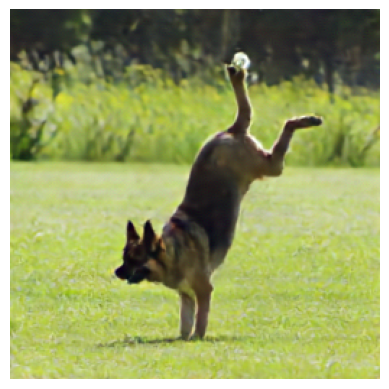

In [13]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

grid = make_grid(
    results[-1, -5:], padding=0, nrow=10
)
def tensor_to_image(tensor):
    return F.to_pil_image(tensor.clamp(0, 1))

img = tensor_to_image(grid)
plt.axis("off")
plt.imshow(img)
plt.show()

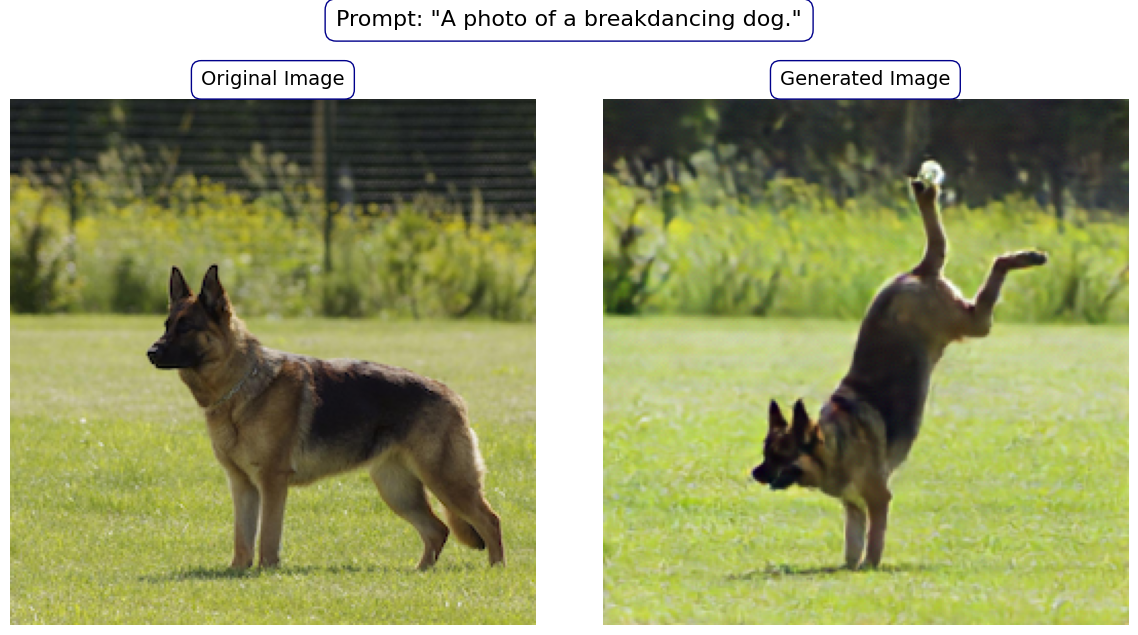

In [14]:
def display_before_after(original_image, generated_image, prompt, figsize=(12, 6)):
    """Display original and generated images side by side with decorative elements"""
    plt.figure(figsize=figsize)
    
    # Create a gradient background
    plt.rcParams['figure.facecolor'] = '#F0F8FF'
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title('Original Image', fontsize=14, pad=10, 
              bbox=dict(facecolor='white', edgecolor='darkblue', boxstyle='round,pad=0.5'))
    
    # Add a decorative border
    plt.gca().spines['bottom'].set_color('darkblue')
    plt.gca().spines['top'].set_color('darkblue') 
    plt.gca().spines['right'].set_color('darkblue')
    plt.gca().spines['left'].set_color('darkblue')
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    
    # Plot generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image)
    plt.axis('off')
    plt.title('Generated Image', fontsize=14, pad=10,
              bbox=dict(facecolor='white', edgecolor='darkblue', boxstyle='round,pad=0.5'))
    
    # Add a decorative border
    plt.gca().spines['bottom'].set_color('darkblue')
    plt.gca().spines['top'].set_color('darkblue')
    plt.gca().spines['right'].set_color('darkblue')
    plt.gca().spines['left'].set_color('darkblue')
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    
    # Add prompt as a subtitle
    plt.suptitle(f'Prompt: "{prompt}"', fontsize=16, y=1.05,
                 bbox=dict(facecolor='white', edgecolor='darkblue', 
                          boxstyle='round,pad=0.5'))
    
    plt.tight_layout()
    plt.show()

# Generate the image
input_prompt = "A photo of a breakdancing dog."
text_embedding = train_ds.get_embed(input_prompt).unsqueeze(0)
noise = torch.randn((1, 3, 256, 256), device=device)
cond_image = ds["original_image"][4].convert("RGB")
                                             
# Convert results to image
transformed_image = tensor_to_image(transform(cond_image))
generated_img = tensor_to_image(results[-1, 0])

results = euler_method(model, text_embedding, t_steps, dt, noise, transform(cond_image).unsqueeze(0).to(device))
# Display the before/after comparison
display_before_after(transformed_image, generated_img, input_prompt)

In [15]:
results.shape

torch.Size([50, 1, 3, 256, 256])

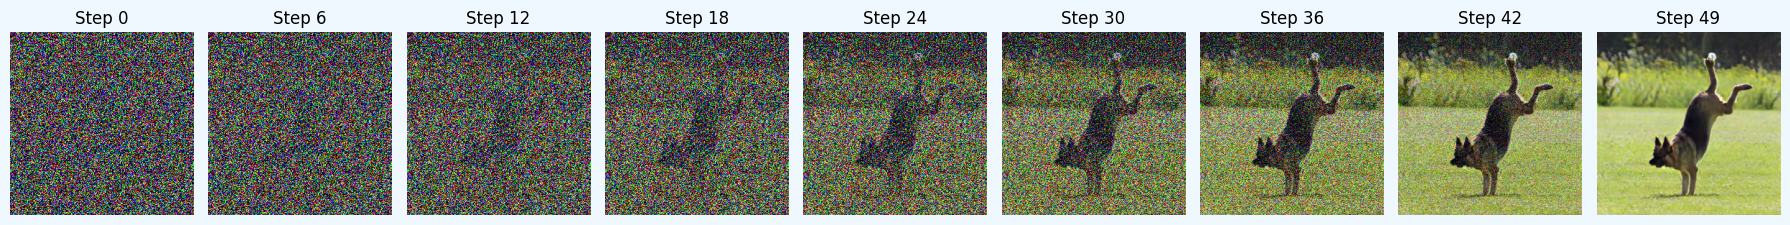

✅ Saved GIF to 'sample_10.gif'


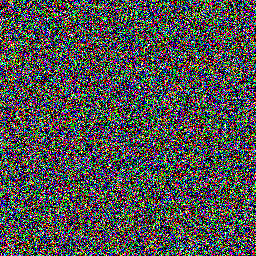

In [16]:
from IPython.display import display, Image as IPyImage

def show_and_save_sampling_progress(results, sample_idx=0, num_steps=9, save_path="sampling.gif", duration=300):
    """
    Hiển thị quá trình sampling (dạng ảnh) và đồng thời lưu thành file GIF.

    Args:
        traj (Tensor): Tensor 5D (T, B, C, H, W)
        sample_idx (int): Index của sample trong batch
        num_steps (int): Số bước sampling để hiển thị và lưu gif
        save_path (str): Đường dẫn file gif muốn lưu
        duration (int): Thời gian mỗi frame (milliseconds)
    """
    T = results.shape[0]
    assert num_steps <= T, "Số bước cần hiển thị phải nhỏ hơn hoặc bằng tổng số bước."

    # Lấy các bước cách đều từ 0 đến T-1
    indices = torch.linspace(0, T - 1, num_steps).long()

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 6))
    frames = []

    for i, idx in enumerate(indices):
        if results.shape[1] == 1:
            # Nếu batch size là 1, chỉ cần lấy ảnh đầu tiên
            sample_idx = 0
        img_tensor = results[idx, sample_idx]  # (C, H, W)
        pil_img = tensor_to_image(img_tensor.cpu())
        frames.append(pil_img)

        # Hiển thị bằng matplotlib
        axes[i].imshow(pil_img)
        axes[i].axis("off")
        axes[i].set_title(f"Step {idx.item()}")

    plt.tight_layout()
    plt.show()

    # Save GIF
    frames[0].save(
        save_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved GIF to '{save_path}'")

    display(IPyImage(filename=save_path))

sample_idx = 10
show_and_save_sampling_progress(results, sample_idx=sample_idx, num_steps=9, save_path=f"sample_{sample_idx}.gif")

In [ ]:
torch.save(
    model.state_dict(),
    "./model/text_guided_image_generation.pth"
)